# LASSO Feature Selection and VAR Forecasting

This notebook performs feature selection using LASSO regression and generates economic forecasts using Vector Autoregression (VAR) models for rental price prediction.

## Key Components:

1. **LASSO Feature Selection**: Uses LASSO regression with cross-validation to identify the most important economic features from 18 available indicators (CPI, WPI, PPI, unemployment rate, GSP, etc.)

2. **Dataset Optimization**: Creates a streamlined dataset containing only the LASSO-selected features along with spatial and temporal identifiers

3. **VAR Economic Forecasting**: Implements a Vector Autoregression model to jointly forecast economic indicators 20 quarters into the future, with special handling for COVID-19 period outliers

4. **COVID-19 Handling**: Applies downweighting strategies to mitigate the impact of extreme COVID-19 quarters (Q2-Q3 2020) on forecast accuracy

The selected features and economic forecasts are saved for use in subsequent modeling notebooks.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.linear_model import WLS
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm
import warnings

In [2]:
# Load the panel data
df = pd.read_csv('../data/curated/rent_growth/panel_data.csv')

In [3]:
# Identify economic features for correlation analysis
economic_features = [
    'cpi', 'wpi', 'ppi', 'unemployment_rate', 'sfd', 'gsp', 'state_final_demand',
    'household_consumption', 'dwelling_investment', 'business_investment', 
    'government_spending', 'population', 'natural_increase', 'net_overseas_migration',
    'net_interstate_migration', 'mortgage_rates', 'savings_rates', 'cash_rate'
]

# Check which features are available in the dataset
available_features = [col for col in economic_features if col in df.columns]
print(f"\nTotal economic features available: {len(available_features)}")



Total economic features available: 18


In [4]:
# LASSO Regression for Feature Selection
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

print("=== LASSO FEATURE SELECTION ===")

# Prepare data for LASSO
X = df[available_features].copy()
y = df['median_rent'].copy()

# Remove rows with missing values
mask = ~(X.isnull().any(axis=1) | y.isnull())
X_clean = X[mask]
y_clean = y[mask]

print(f"Data shape: {X_clean.shape}")
print(f"Target variable: median_rent")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# LASSO with cross-validation
lasso_cv = LassoCV(cv=tscv, random_state=42, max_iter=2000)
lasso_cv.fit(X_scaled, y_clean)

print(f"\nLASSO Results:")
print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")

# Get selected features (non-zero coefficients)
selected_features = [available_features[i] for i in range(len(available_features)) if lasso_cv.coef_[i] != 0]
print(f"Features selected: {len(selected_features)}")
print(f"Selected features: {selected_features}")

# Show all coefficients
coef_df = pd.DataFrame({
    'feature': available_features,
    'coefficient': lasso_cv.coef_,
    'abs_coefficient': np.abs(lasso_cv.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nAll coefficients (sorted by importance):")
print(coef_df)


=== LASSO FEATURE SELECTION ===
Data shape: (41918, 18)
Target variable: median_rent

LASSO Results:
Optimal alpha: 0.214182
Features selected: 12
Selected features: ['cpi', 'wpi', 'ppi', 'unemployment_rate', 'gsp', 'household_consumption', 'dwelling_investment', 'government_spending', 'population', 'natural_increase', 'net_interstate_migration', 'mortgage_rates']

All coefficients (sorted by importance):
                     feature  coefficient  abs_coefficient
15            mortgage_rates    35.575413        35.575413
12          natural_increase   -33.594163        33.594163
11                population   -30.979976        30.979976
14  net_interstate_migration    24.290993        24.290993
2                        ppi    21.373666        21.373666
0                        cpi   -14.525153        14.525153
3          unemployment_rate   -13.505630        13.505630
1                        wpi    -8.350126         8.350126
7      household_consumption    -7.903488         7.903488
5

In [5]:
# Create optimised dataset with LASSO-selected features
print("=== CREATING OPTIMISED DATASET ===")

# Create dataset with selected features
df_subset = df[['date', 'year', 'quarter'] + selected_features + [ 'suburb', 'property_type', 'median_rent', 'population_size', 'median_personal_income', 'median_age']].copy()


print(f"Selected features: {selected_features}")
print(f"Number of features: {len(selected_features)}")


=== CREATING OPTIMISED DATASET ===
Selected features: ['cpi', 'wpi', 'ppi', 'unemployment_rate', 'gsp', 'household_consumption', 'dwelling_investment', 'government_spending', 'population', 'natural_increase', 'net_interstate_migration', 'mortgage_rates']
Number of features: 12


In [6]:
# Drop missing values from gsp column
df_subset = df_subset.dropna(subset=['gsp']).reset_index(drop=True)
print(df_subset)

             date  year  quarter  cpi  wpi  ppi  unemployment_rate     gsp  \
0      2013-06-01  2013        2  2.2  3.0  1.2           5.805300  2.4049   
1      2013-06-01  2013        2  2.2  3.0  1.2           5.805300  2.4049   
2      2013-06-01  2013        2  2.2  3.0  1.2           5.805300  2.4049   
3      2013-06-01  2013        2  2.2  3.0  1.2           5.805300  2.4049   
4      2013-06-01  2013        2  2.2  3.0  1.2           5.805300  2.4049   
...           ...   ...      ...  ...  ...  ...                ...     ...   
41913  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.9711   
41914  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.9711   
41915  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.9711   
41916  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.9711   
41917  2025-03-01  2025        1  2.3  3.3  3.7           4.544433  1.9711   

       household_consumption  dwelling_investment  ...  populat

In [7]:
# # create spatial idexes
df_subset['spatial_unit'] = df_subset['suburb'] + '_' + df_subset['property_type'].str.replace(' ', '_')

# Create time and spatial indices
df_subset['time_index'] = df_subset.groupby('date').ngroup()
df_subset['spatial_index'] = df_subset.groupby('spatial_unit').ngroup()

# save df_subset
df_subset.to_csv('../data/curated/rent_growth/panel_data_selected.csv', index=False)



In [8]:
# VAR forecasting with COVID period downweighting
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

def predict_future_features_with_covid_handling(time_features, df, forecast_steps=20, covid_downweight=True):
    """ 
    Use a VAR model to jointly forecast the time dependent features with COVID period handling
    
    Parameters:
    - time_features: List of economic/time-dependent feature names
    - df: DataFrame with time series data
    - forecast_steps: Number of periods to forecast
    - covid_downweight: Whether to downweight COVID period (2020-2022)
    
    Returns:
    - forecast_df: DataFrame with forecasted features
    """
    
    # Filter to only available features
    available_features = [f for f in time_features if f in df.columns]
    print(f"Available time features for VAR: {available_features}")
    
    if not available_features:
        print("No time features available for VAR modeling")
        return None
    
    # Create time series data for features (aggregated by time period)
    time_data = df.groupby(['year', 'quarter'])[available_features].first().reset_index()
    time_data = time_data.sort_values(['year', 'quarter'])
    
    # Remove any rows with NaN values
    to_forecast = time_data[available_features].dropna()
    time_info = time_data[['year', 'quarter']].iloc[:len(to_forecast)]
    
    print(f"VAR data shape: {to_forecast.shape}")
    print(f"Features: {available_features}")
    
    if len(to_forecast) < 10:
        print("Not enough data points for VAR modeling")
        return None
    
    # COVID period downweighting strategy
    if covid_downweight:
        print("Applying COVID period downweighting strategy...")
        
        # Method 1: Remove extreme COVID quarters entirely (Q2-Q3 2020)
        extreme_covid_mask = (time_info['year'] == 2020) & (time_info['quarter'].isin([2, 3]))
        to_forecast_clean = to_forecast[~extreme_covid_mask].reset_index(drop=True)
        time_info_clean = time_info[~extreme_covid_mask].reset_index(drop=True)
        
        print(f"Removed {extreme_covid_mask.sum()} extreme COVID quarters")
        print(f"Clean VAR data shape: {to_forecast_clean.shape}")
        
        if len(to_forecast_clean) >= 8:
            to_forecast_final = to_forecast_clean
            time_info_final = time_info_clean
            scaler = None
            print("Using COVID-filtered dataset")
        else:
            print("Not enough data after COVID filtering, using full dataset with outlier treatment")
            to_forecast_final = to_forecast
            time_info_final = time_info
            scaler = None
    else:
        to_forecast_final = to_forecast
        time_info_final = time_info
        scaler = None
    
    try:
        # Fit VAR model with reduced lag order for stability
        model = VAR(to_forecast_final)
        
        # Use fewer lags to reduce overfitting with limited data
        max_lags = min(2, len(to_forecast_final) // 10)  
        
        results = model.fit(maxlags=max_lags)
        print(f"VAR model fitted successfully with {results.k_ar} lags")
        
        # Forecast the features
        forecast = results.forecast(to_forecast_final.values[-results.k_ar:], steps=forecast_steps)
        
        # Convert into a DataFrame
        forecast_df = pd.DataFrame(forecast, columns=available_features)
        
        # Apply reasonable bounds to forecasts based on historical data ranges
        historical_stats = to_forecast.describe()
        for col in available_features:
            if col in historical_stats.columns:
                # Get historical min/max and add some buffer
                hist_min = historical_stats.loc['min', col]
                hist_max = historical_stats.loc['max', col]
                hist_mean = historical_stats.loc['mean', col]
                hist_std = historical_stats.loc['std', col]
                
                # Set bounds based on historical data ± 2 standard deviations
                lower_bound = max(hist_min, hist_mean - 2 * hist_std)
                upper_bound = min(hist_max, hist_mean + 2 * hist_std)
                
                # Apply additional reasonable bounds for specific indicators
                if 'rate' in col.lower() or 'cpi' in col.lower() or 'wpi' in col.lower():
                    lower_bound = max(lower_bound, -5)  # Don't go below -5%
                    upper_bound = min(upper_bound, 10)  # Don't go above 10%
                elif 'gsp' in col.lower() or 'growth' in col.lower():
                    lower_bound = max(lower_bound, -10)  # Don't go below -10%
                    upper_bound = min(upper_bound, 15)   # Don't go above 15%
                
                forecast_df[col] = np.clip(forecast_df[col], lower_bound, upper_bound)
                print(f"{col}: bounded to [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        print(f"VAR forecasts generated for {forecast_steps} periods")
        print("Applied reasonable bounds to economic indicators")
        return forecast_df
        
    except Exception as e:
        print(f"Error fitting VAR model: {e}")
        print("Falling back to simple trend extrapolation...")
        
        # Fallback: Simple trend extrapolation
        forecast_df = pd.DataFrame(index=range(forecast_steps), columns=available_features)
        
        for col in available_features:
            # Use last 4 quarters for trend calculation (excluding extreme COVID values)
            recent_data = to_forecast[col].tail(4)
            if covid_downweight:
                # Exclude 2020 Q2-Q3 from trend calculation
                recent_mask = ~((time_info['year'] == 2020) & (time_info['quarter'].isin([2, 3])))
                if recent_mask.sum() >= 2:
                    recent_data = to_forecast[col][recent_mask].tail(4)
            
            # Simple linear trend
            if len(recent_data) >= 2:
                trend = recent_data.diff().mean()
                last_value = recent_data.iloc[-1]
                forecast_values = [last_value + trend * (i+1) for i in range(forecast_steps)]
                
                # Apply same bounds as VAR model
                historical_stats = to_forecast.describe()
                if col in historical_stats.columns:
                    hist_min = historical_stats.loc['min', col]
                    hist_max = historical_stats.loc['max', col]
                    hist_mean = historical_stats.loc['mean', col]
                    hist_std = historical_stats.loc['std', col]
                    
                    lower_bound = max(hist_min, hist_mean - 2 * hist_std)
                    upper_bound = min(hist_max, hist_mean + 2 * hist_std)
                    
                    if 'rate' in col.lower() or 'cpi' in col.lower() or 'wpi' in col.lower():
                        lower_bound = max(lower_bound, -5)
                        upper_bound = min(upper_bound, 10)
                    elif 'gsp' in col.lower() or 'growth' in col.lower():
                        lower_bound = max(lower_bound, -10)
                        upper_bound = min(upper_bound, 15)
                    
                    forecast_df[col] = np.clip(forecast_values, lower_bound, upper_bound)
                else:
                    forecast_df[col] = forecast_values
            else:
                # If no trend available, use last value
                forecast_df[col] = recent_data.iloc[-1]
        
        return forecast_df

# Keep original function for compatibility
def predict_future_features(time_features, df, forecast_steps=20):
    """Original function - now uses COVID handling by default"""
    return predict_future_features_with_covid_handling(time_features, df, forecast_steps, covid_downweight=True)

print("Enhanced VAR forecasting with COVID handling defined successfully!")


Enhanced VAR forecasting with COVID handling defined successfully!


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def model_var_results(time_features, df, forecast_steps=20):
    forecast_df = predict_future_features(time_features, df, forecast_steps)
    if forecast_df is None:
        return
    
    # Reconstruct historical time series for plotting with proper dates
    time_data = df.groupby(['year', 'quarter'])[time_features].first().reset_index()
    time_data = time_data.sort_values(['year', 'quarter']).reset_index(drop=True)
    
    # Only keep features actually forecasted
    available_features = [f for f in time_features if f in forecast_df.columns]
    time_data = time_data[available_features]
    
    # Create proper time index using actual data dates
    # Convert year and quarter to proper dates
    quarter_to_month = {1: 1, 2: 4, 3: 7, 4: 10}
    time_data_with_dates = df.groupby(['year', 'quarter'])[time_features].first().reset_index()
    time_data_with_dates = time_data_with_dates.sort_values(['year', 'quarter']).reset_index(drop=True)
    time_data_with_dates['month'] = time_data_with_dates['quarter'].map(quarter_to_month)
    time_data_with_dates['date'] = pd.to_datetime(time_data_with_dates[['year', 'month']].assign(day=1))
    
    # Use actual dates for historical data
    time_index = time_data_with_dates['date']
    
    # Create forecast dates starting from the last historical date
    forecast_index = pd.date_range(
        start=time_index.iloc[-1] + pd.offsets.QuarterBegin(),
        periods=forecast_steps,
        freq='Q'
    )
    
    # Plot each feature
    plt.figure(figsize=(15, 8))
    # Use consistent colors for each feature (historical and forecast)
    import itertools
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    feature_colors = {feature: next(color_cycle) for feature in available_features}
    for feature in available_features:
        color = feature_colors[feature]
        plt.plot(time_index, time_data[feature], label=f'{feature} (historical)', linewidth=2, color=color)
        plt.plot(forecast_index, forecast_df[feature], '--', label=f'{feature} (forecast)', linewidth=2, color=color)
    plt.title("VAR Model Forecast vs Historical Features (with COVID Downweighting)", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Feature values", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== FORECAST SUMMARY ===")
    print(f"Historical data range: {time_index.iloc[0].strftime('%Y-%m')} to {time_index.iloc[-1].strftime('%Y-%m')}")
    print(f"Forecast range: {forecast_index[0].strftime('%Y-%m')} to {forecast_index[-1].strftime('%Y-%m')}")
    
    # Optionally return forecast for further use
    return forecast_df


In [10]:
# Generate VAR forecasts for economic features
print("=== GENERATING VAR FORECASTS FOR ECONOMIC FEATURES ===")

# Use the simplified VAR function to forecast selected economic features
economic_forecasts = predict_future_features(selected_features, df_subset, forecast_steps=20)

if economic_forecasts is not None:
    print(f"\nEconomic forecasts shape: {economic_forecasts.shape}")
    print(f"Forecasted features: {list(economic_forecasts.columns)}")
    print(f"\nSample economic forecasts (first 5 periods):")
    print(economic_forecasts.head())
    
    # Show how economic features change over time
    print(f"\nEconomic feature changes (first vs last period):")
    for col in economic_forecasts.columns:
        first_val = economic_forecasts[col].iloc[0]
        last_val = economic_forecasts[col].iloc[-1]
        change = ((last_val - first_val) / first_val) * 100
        print(f"{col}: {first_val:.4f} → {last_val:.4f} ({change:+.2f}%)")
else:
    print("VAR forecasting failed, will use static economic values")

print("\nVAR economic forecasting completed!")





=== GENERATING VAR FORECASTS FOR ECONOMIC FEATURES ===
Available time features for VAR: ['cpi', 'wpi', 'ppi', 'unemployment_rate', 'gsp', 'household_consumption', 'dwelling_investment', 'government_spending', 'population', 'natural_increase', 'net_interstate_migration', 'mortgage_rates']
VAR data shape: (48, 12)
Features: ['cpi', 'wpi', 'ppi', 'unemployment_rate', 'gsp', 'household_consumption', 'dwelling_investment', 'government_spending', 'population', 'natural_increase', 'net_interstate_migration', 'mortgage_rates']
Applying COVID period downweighting strategy...
Removed 2 extreme COVID quarters
Clean VAR data shape: (46, 12)
Using COVID-filtered dataset
VAR model fitted successfully with 2 lags
cpi: bounded to [0.30, 6.10]
wpi: bounded to [1.40, 3.70]
ppi: bounded to [-0.40, 5.61]
unemployment_rate: bounded to [3.54, 6.94]
gsp: bounded to [-1.20, 6.51]
household_consumption: bounded to [-4.49, 6.98]
dwelling_investment: bounded to [-0.98, 1.37]
government_spending: bounded to [-1.0

Available time features for VAR: ['cpi', 'wpi', 'ppi', 'unemployment_rate', 'gsp', 'household_consumption', 'dwelling_investment', 'government_spending', 'population', 'natural_increase', 'net_interstate_migration', 'mortgage_rates']
VAR data shape: (48, 12)
Features: ['cpi', 'wpi', 'ppi', 'unemployment_rate', 'gsp', 'household_consumption', 'dwelling_investment', 'government_spending', 'population', 'natural_increase', 'net_interstate_migration', 'mortgage_rates']
Applying COVID period downweighting strategy...
Removed 2 extreme COVID quarters
Clean VAR data shape: (46, 12)
Using COVID-filtered dataset
VAR model fitted successfully with 2 lags
cpi: bounded to [0.30, 6.10]
wpi: bounded to [1.40, 3.70]
ppi: bounded to [-0.40, 5.61]
unemployment_rate: bounded to [3.54, 6.94]
gsp: bounded to [-1.20, 6.51]
household_consumption: bounded to [-4.49, 6.98]
dwelling_investment: bounded to [-0.98, 1.37]
government_spending: bounded to [-1.01, 2.57]
population: bounded to [-0.17, 2.82]
natural_i

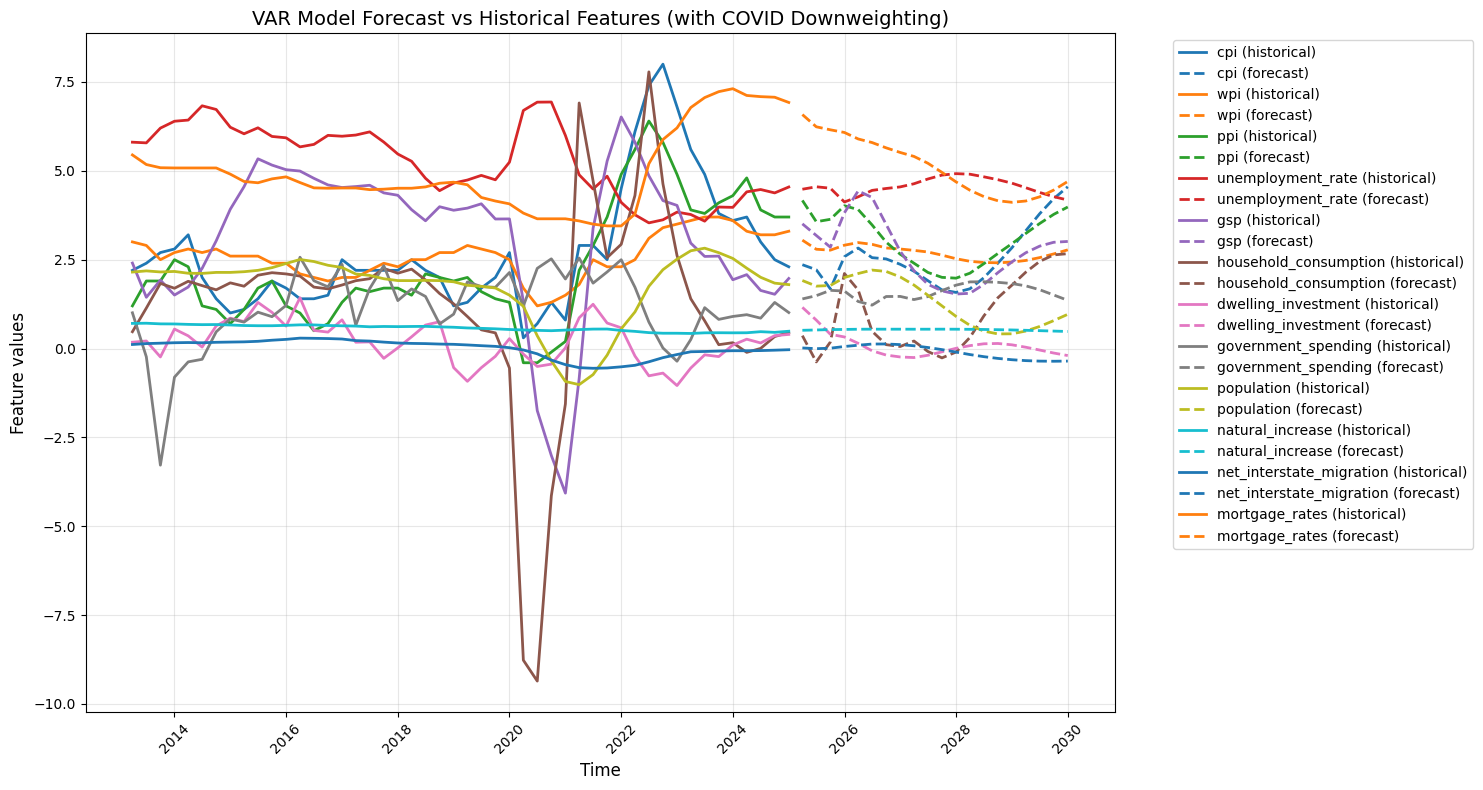


=== FORECAST SUMMARY ===
Historical data range: 2013-04 to 2025-01
Forecast range: 2025-03 to 2029-12


In [11]:
economic_forecast = model_var_results(selected_features, df_subset, forecast_steps=20)

# Save the economic_forecast DataFrame to a CSV file
economic_forecast.to_csv('../data/curated/rent_growth/economic_forecast.csv', index=False)

